In [80]:
from abc import ABC, abstractmethod
import numpy as np
import math
import matplotlib.pyplot as plt
from numba import jit, prange

In [92]:
class Image(ABC):
    def __init__(self, width: int = 800, height: int = 800):
        if width <= 0 or height <= 0:
            raise ValueError("width and height must be positive integers.")
        self._width = width
        self._height = height
        # TODO: use float instead of np.float32
        self._image = np.zeros((self._height, self._width), dtype=float)

    @property
    def resolution(self) -> tuple[int, int]:
        return self._width, self._height

    @resolution.setter
    def resolution(self, res: tuple[int, int]):
        w, h = res
        if w <= 0 or h <= 0:
            raise ValueError("Resolution must be positive integers.")
        self._width = w
        self._height = h
        # TODO: refactor not to reset image?
        self._image = np.zeros((self._height, self._width), dtype=float)  # Reset image

    @abstractmethod
    def render(self) -> np.ndarray:
        """Render the image and return a 2D NumPy array."""
        pass

    def image(self) -> np.ndarray:
        """Returns the last rendered image data."""
        return self._image

    def plot(self, cmap: str = "turbo"):
        """Plot the rendered image using matplotlib."""
        plt.figure(figsize=(10, 10))
        plt.imshow(self._image, cmap=cmap)
        plt.axis('off')
        plt.show()

    def equalize_histogram(self):
        """Apply histogram equalization to a 2D numpy array."""
        hist, bins = np.histogram(self._image.flatten(), bins=512, density=True)
        cdf = hist.cumsum()  # cumulative distribution function
        cdf = cdf / cdf[-1]  # normalize to [0,1]
        # Use linear interpolation of cdf to find new pixel values
        image_flat = np.interp(self._image.flatten(), bins[:-1], cdf)
        self._image = image_flat.reshape(self._image.shape)

In [93]:
class Fractal(Image):
    def __init__(self, x_min: float = -2.0, x_max: float = 1.0, y_min: float = -1.5, y_max: float = 1.5, max_iter: int = 1000):
        self._x_min = x_min
        self._x_max = x_max
        self._y_min = y_min
        self._y_max = y_max
        if max_iter <= 0:
            raise ValueError("max_iter and height must be positive integers.")
        self._max_iter = max_iter

    @abstractmethod
    def compute(self) -> np.ndarray:
        pass

    @property
    def max_iter(self) -> int:
        return self._max_iter

    @max_iter.setter
    def max_iter(self, value: int):
        if value <= 0:
            raise ValueError("max_iter must be a positive integer.")
        self._max_iter = value

    def plot(self, cmap: str = "turbo"):
        """Plot the rendered image using matplotlib."""
        plt.figure(figsize=(10, 10))
        plt.imshow(self._image, cmap=cmap, extent=[self._x_min, self._x_max, self._y_min, self._y_max])
        plt.show()

    def set_zoom(self, zoom: float, center: tuple[float, float]):
        delta = 2 / zoom
        self._x_min, self._y_min = center[0] - delta, center[1] - delta
        self._x_max, self._y_max = center[0] + delta, center[1] + delta

    def render(self) -> np.ndarray:
        width, height = self.resolution
        return self.compute()

In [94]:
@jit(nopython=True, parallel=True, fastmath=True)
def compute_mandelbrot(x_min, x_max, y_min, y_max, width, height, max_iter):
    # TODO: use float instead if np.float32
    result = np.zeros((height, width), dtype=float)

    scale_x = (x_max - x_min) / width
    scale_y = (y_max - y_min) / height

    log2 = math.log(2.0)

    for y in prange(height):
        zy = y_min + y * scale_y
        for x in range(width):
            zx = x_min + x * scale_x
            zr, zi = 0.0, 0.0
            cr, ci = zx, zy
            n = 0

            while zr * zr + zi * zi <= 4.0 and n < max_iter:
                zr2 = zr * zr - zi * zi + cr
                zi = 2.0 * zr * zi + ci
                zr = zr2
                n += 1

            if n < max_iter:
                mag_sq = zr * zr + zi * zi
                log_zn = 0.5 * math.log(mag_sq)
                nu = math.log(log_zn / log2) / log2
                result[y, x] = n + 1 - nu
            else:
                result[y, x] = n
    return result


class Mandelbrot(Fractal):
    def compute(self):
        width, height = self.resolution
        self._image = compute_mandelbrot(self._x_min, self._x_max, self._y_min, self._y_max, self._width, self._height, self._max_iter)

#       x = np.linspace(xmin, xmax, width)
#       y = np.linspace(ymin, ymax, height)
#       C = x[:, np.newaxis] + 1j * y[np.newaxis, :]
#       Z = np.zeros_like(C)
#       div_time = np.zeros(C.shape, dtype=int)
#
#       for i in range(self._max_iter):
#           Z = Z**2 + C
#           diverge = np.abs(Z) > 2
#           div_now = diverge & (div_time == 0)
#           div_time[div_now] = i
#           Z[diverge] = 2
#
#       return div_time.T

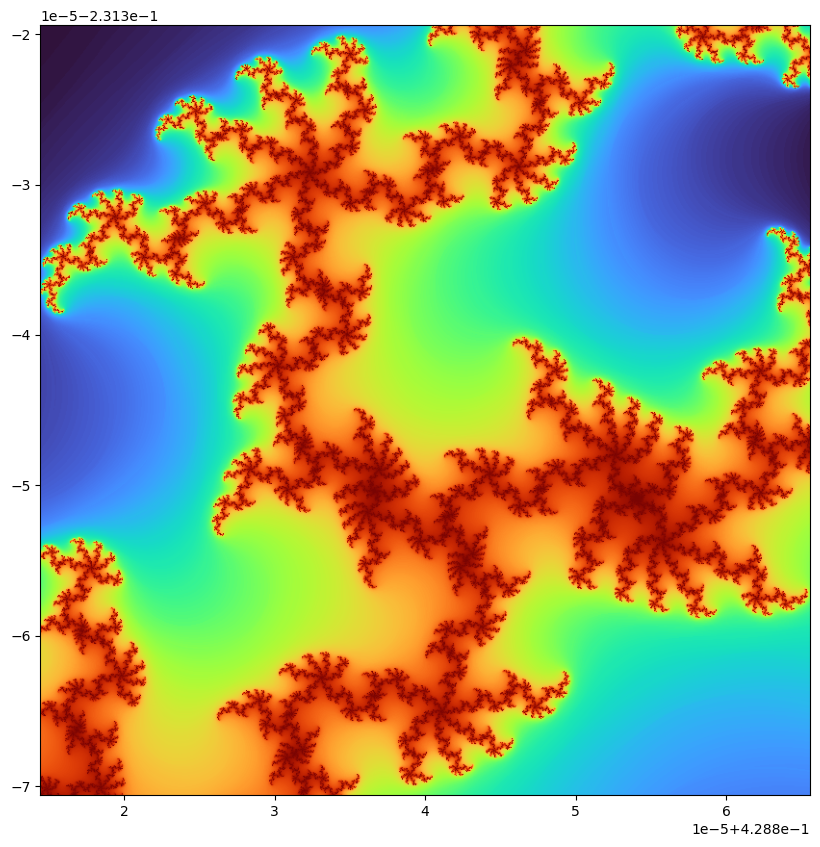

CPU times: user 1.37 s, sys: 394 ms, total: 1.77 s
Wall time: 263 ms


In [96]:
%%time
m = Mandelbrot()
m.resolution = 800, 800
m.max_iter = 10000

#m.set_zoom(5, (-0.170337,-1.06506))
#m.set_zoom(25, (-0.170337,-1.06506))
#m.set_zoom(125, (-0.170337,-1.06506))
#m.set_zoom(625, (-0.170337,-1.06506))
#m.set_zoom(3125, (-0.170337,-1.06506))
#m.set_zoom(15625, (-0.170337,-1.06506))
#m.set_zoom(78125, (-0.170337,-1.06506))

#m.set_zoom(5, (0.42884,-0.231345))
#m.set_zoom(25, (0.42884,-0.231345))
#m.set_zoom(125, (0.42884,-0.231345))
#m.set_zoom(625, (0.42884,-0.231345))
#m.set_zoom(3125, (0.42884,-0.231345))
#m.set_zoom(15625, (0.42884,-0.231345))
m.set_zoom(78125, (0.42884,-0.231345))

#m.set_zoom(5, (-1.62917,-0.0203968))
#m.set_zoom(25, (-1.62917,-0.0203968))
#m.set_zoom(125, (-1.62917,-0.0203968))
#m.set_zoom(625, (-1.62917,-0.0203968))
#m.set_zoom(3125, (-1.62917,-0.0203968))
#m.set_zoom(15625, (-1.62917,-0.0203968))
#m.set_zoom(78125, (-1.62917,-0.0203968))

#m.set_zoom(5, (-0.761574,-0.0847596))
#m.set_zoom(25, (-0.761574,-0.0847596))
#m.set_zoom(125, (-0.761574,-0.0847596))
#m.set_zoom(625, (-0.761574,-0.0847596))
#m.set_zoom(3125, (-0.761574,-0.0847596))
#m.set_zoom(15625, (-0.761574,-0.0847596))
#m.set_zoom(78125, (-0.761574,-0.0847596))

m.render()
m.equalize_histogram()
m.plot()

In [ ]:
%%time
m = Mandelbrot()
m.resolution = 1200, 1200
m.max_iter = 100
m.plot()